In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

# 修正したモデルから卒論時に集計したデータを作成する

1. 表

| ベンチマーク名 | 平均誤差率(%) | コスト比(%) |
|---------|----------|---------|


2. 表

| ベンチマーク名 | 採用割合(最大MAPE(%), 最小MAPE(%)) |
|---------|----------------------------|
|         | モデル(1), モデル(2), ...        |


<Figure size 288x216 with 0 Axes>

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均誤差率(%)')

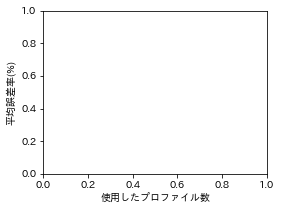

In [2]:
plt.figure(figsize=(4,3))
plt.xlabel("使用したプロファイル数")
plt.ylabel("平均誤差率(%)")

In [5]:
# 実験結果を集計するためのデータフレームのカラムの名称のリストを返す関数
def return_numOfColumns():
    returnList = []
    # ベンチマーク名
    returnList.append("benchmarkName")
    # 関数名
    returnList.append("functionName")
    # 使用データ(数値化されたリスト)
    returnList.append("usedData")
    # 使用データ数
    returnList.append("numOfData")
    # 固定したもの("Process" or "Class")
    returnList.append("fixed")
    # 予測対象プロセス数
    returnList.append("numOfProcess")
    # 予測対象問題サイズ
    returnList.append("numOfProblemSize")
    # 予測対象関数コール回数
    returnList.append("targetNumOfFunctionCall")
    # 線形モデルのオブジェクト
    returnList.append("objectLinModel")
    # 線形モデルの相対誤差
    returnList.append("relativeErrorOfLinModel")
    # 反比例モデルのオブジェクト
    returnList.append("objectIpModel")
    # 反比例モデルの相対誤差
    returnList.append("relativeErrorOfIpModel")
    # 対数モデルのオブジェクト
    returnList.append("objectLogModel")
    # 対数モデルの相対誤差
    returnList.append("relativeErrorOfLogModel")
    # 線形飽和モデルのオブジェクト
    returnList.append("objectBranchModel")
    # 線形飽和モデルの相対誤差
    returnList.append("relativeErrorOfBranchModel")
    
    return(returnList)

columnNames = return_numOfColumns()

df_simple = pd.DataFrame(columns=columnNames)
df_simple

,benchmarkName,functionName,usedData,numOfData,fixed,numOfProcess,numOfProblemSize,targetNumOfFunctionCall,objectLinModel,relativeErrorOfLinModel,objectIpModel,relativeErrorOfIpModel,objectLogModel,relativeErrorOfLogModel,objectBranchModel,relativeErrorOfBranchModel
